In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5
mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sqlalchemy import create_engine

# Установка соединения с базой данных
conn_uri = "SQLALCHEMY_DATABASE_URL"
engine = create_engine(conn_uri)

In [4]:
post_text = pd.read_sql("SELECT * FROM public.post_text_df;", conn_uri)
post_text.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [5]:
### Посмотрим на категориальные колонки
post_text.describe(include='object')

,text,topic
count,7023,7023
unique,6924,7
top,Microsoft gets the blogging bug\n\nSoftware gi...,movie
freq,2,3000


In [6]:
### Посмотрим на вещественные колонки
post_text.describe()

,post_id
count,7023.000000
mean,3666.533817
std,2109.613383
min,1.000000
25%,1849.500000
50%,3668.000000
75%,5492.000000
max,7319.000000


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Преобразование текста в TF-IDF векторы
tfidf = TfidfVectorizer(stop_words='english', max_features = 1500)  
tfidf_matrix = tfidf.fit_transform(post_text['text'].fillna('unknown'))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.reset_index(drop=True, inplace=True)
post_text.reset_index(drop=True, inplace=True)
tfidf_df.head()

,000,10,100,11,12,13,14,15,16,17,...,wrote,year,years,yes,york,youll,young,younger,youre,yukos
0,0.00000,0.000000,0.000000,0.0,0.067016,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.083771,0.087437,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.21875,0.000000,0.069026,0.0,0.064907,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.042343,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.07891,0.069267,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.052942,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,0.000000,0.0,0.000000,0.084532,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Обработка текста

tfidf = TfidfVectorizer(stop_words='english', max_features = 1500)  
tfidf_matrix = tfidf.fit_transform(post_text['text'].fillna('unknown'))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.reset_index(drop=True, inplace=True)
post_text.reset_index(drop=True, inplace=True)
tfidf_df.head()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_matrix.toarray())
pca = PCA(n_components=1000)  
X_pca = pca.fit_transform(X_scaled)

n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_
df_results = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_results['pca_cluster'] = labels
post_text['pca_cluster'] = df_results['pca_cluster']

post_text['text_length'] = post_text['text'].apply(len)
post_text = post_text.drop('text', axis = 1)

In [9]:
### Извлечение данных с таргетом 1 и 0 с соотношением 2:1
query_positive_target = """
WITH sampled_feed AS (
    SELECT *
    FROM public.feed_data
    WHERE target = 1
    ORDER BY RANDOM()
    LIMIT 5000000
)
SELECT *
FROM sampled_feed
"""

query_negative_target = """
WITH sampled_feed AS (
    SELECT *
    FROM public.feed_data
    WHERE target = 0
    ORDER BY RANDOM()
    LIMIT 2500000
)
SELECT *
FROM sampled_feed
"""

data_positive = pd.read_sql(query_positive_target, engine)
data_negative = pd.read_sql(query_negative_target, engine)

feed_data = pd.concat([data_positive, data_negative], ignore_index=True)
feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-18 07:27:26,38969,5716,view,1
1,2021-11-24 06:40:00,152505,4990,view,1
2,2021-12-28 16:22:26,134751,2663,view,1
3,2021-11-21 08:03:04,122005,3336,view,1
4,2021-12-29 19:20:35,17061,5001,view,1


In [10]:
user_data = pd.read_sql("SELECT * FROM public.user_data;", conn_uri)
user_data.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [11]:
data = pd.merge(feed_data, user_data, on='user_id', how='left')

In [12]:
del feed_data
del user_data

In [13]:
import gc

gc.collect()

124

In [14]:
### Посмотрим на категориальные колонки
data.describe(include = 'object')

,action,country,city,os,source
count,7500000,7500000,7500000,7500000,7500000
unique,2,11,3915,2,2
top,view,Russia,Moscow,Android,ads
freq,7201116,6319354,1198080,4862941,4671508


In [15]:
### Посмотрим на вещественные колонки
data.describe()

,user_id,post_id,target,gender,age,exp_group
count,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06
mean,8.508176e+04,3.408165e+03,6.666667e-01,5.763321e-01,2.720674e+01,1.973832e+00
std,4.898056e+04,2.097541e+03,4.714046e-01,4.941391e-01,1.023758e+01,1.362737e+00
min,2.000000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,0.000000e+00
25%,4.103900e+04,1.533000e+03,0.000000e+00,0.000000e+00,2.000000e+01,1.000000e+00
50%,8.552900e+04,3.217000e+03,1.000000e+00,1.000000e+00,2.400000e+01,2.000000e+00
75%,1.277470e+05,5.227000e+03,1.000000e+00,1.000000e+00,3.300000e+01,3.000000e+00
max,1.685520e+05,7.319000e+03,1.000000e+00,1.000000e+00,9.500000e+01,4.000000e+00


In [16]:
### Обработка временных данных и сортировка
data['timestamp'] = pd.to_datetime(data['timestamp'])

data = data.sort_values(by=['user_id', 'timestamp'], ascending=[True, True])

data['hour'] = data.timestamp.dt.hour
data['month'] = data.timestamp.dt.month
data['day_of_week'] = data.timestamp.dt.dayofweek
data['day'] = data.timestamp.dt.day

In [17]:
### Дополнительные признаки
user_views = data[data['action'] == 'view'].groupby('user_id')['post_id'].nunique().rename('user_views')

user_likes = data[data['action'] == 'like'].groupby('user_id')['post_id'].nunique().rename('user_likes')

data = data.merge(user_views, on='user_id', how='left').merge(user_likes, on='user_id', how='left')
data['post_likes'] = data.groupby('post_id')['target'].transform('sum')

data = data.fillna(0)

data = data.drop('action', axis = 1)
data = data.drop('timestamp', axis = 1)

In [18]:
### Объединение с датафреймом post_text

data = pd.merge(data, post_text, on='post_id', how='left')
data.head()

,user_id,post_id,target,gender,age,country,city,exp_group,os,source,hour,month,day_of_week,day,user_views,user_likes,post_likes,topic,pca_cluster,text_length
0,200,6264,1,1,34,Russia,Degtyarsk,3,Android,ads,14,10,5,2,42,3.0,428,movie,17,3381
1,200,6264,0,1,34,Russia,Degtyarsk,3,Android,ads,14,10,5,2,42,3.0,428,movie,17,3381
2,200,6635,1,1,34,Russia,Degtyarsk,3,Android,ads,14,10,5,2,42,3.0,448,movie,17,483
3,200,668,1,1,34,Russia,Degtyarsk,3,Android,ads,15,10,2,6,42,3.0,649,entertainment,68,2581
4,200,2532,1,1,34,Russia,Degtyarsk,3,Android,ads,15,10,2,6,42,3.0,433,covid,2,135


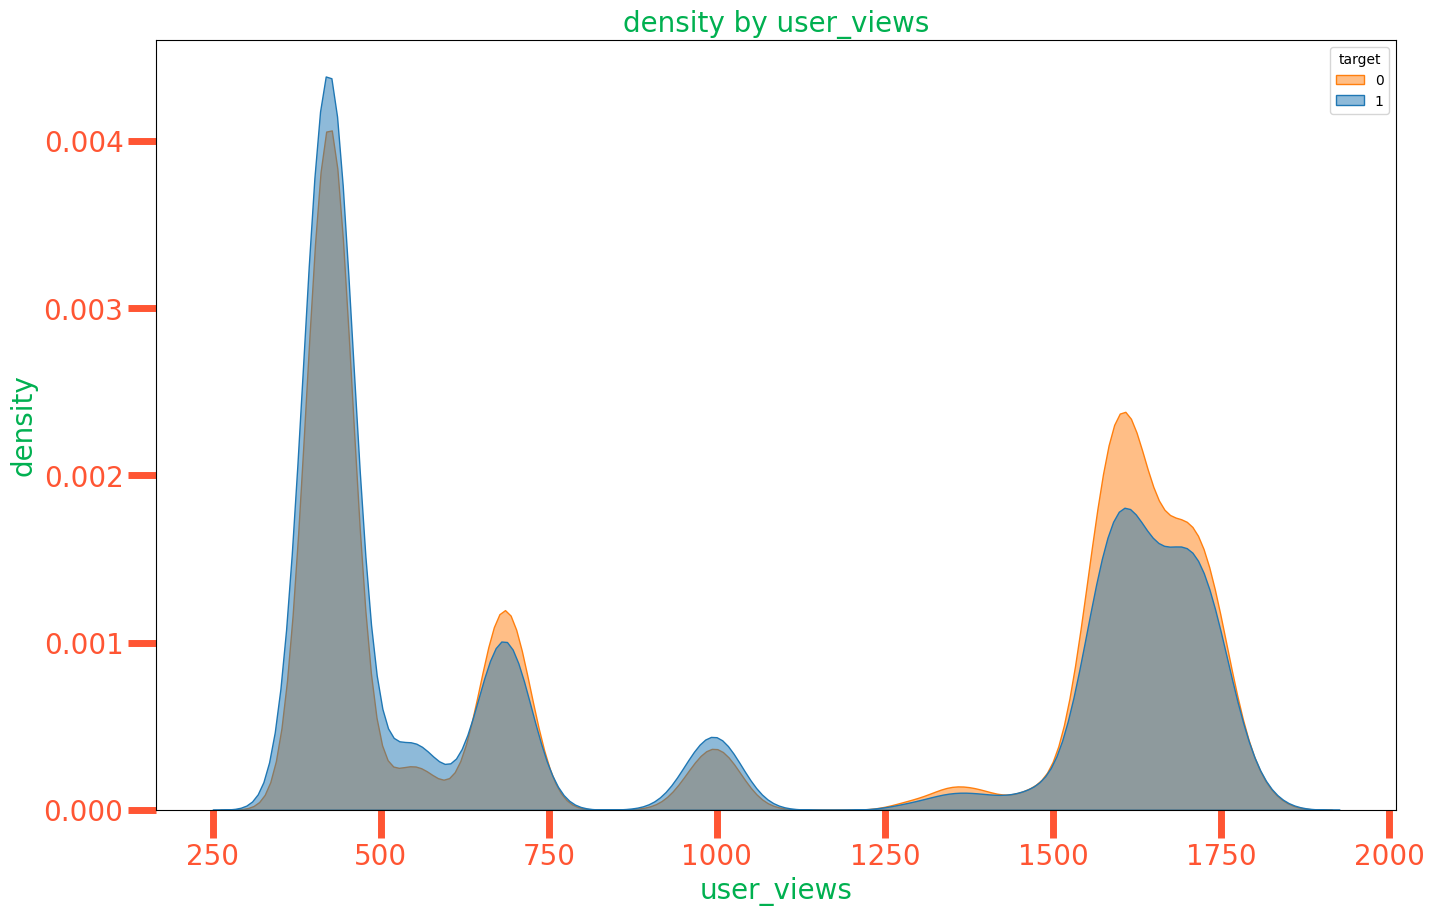

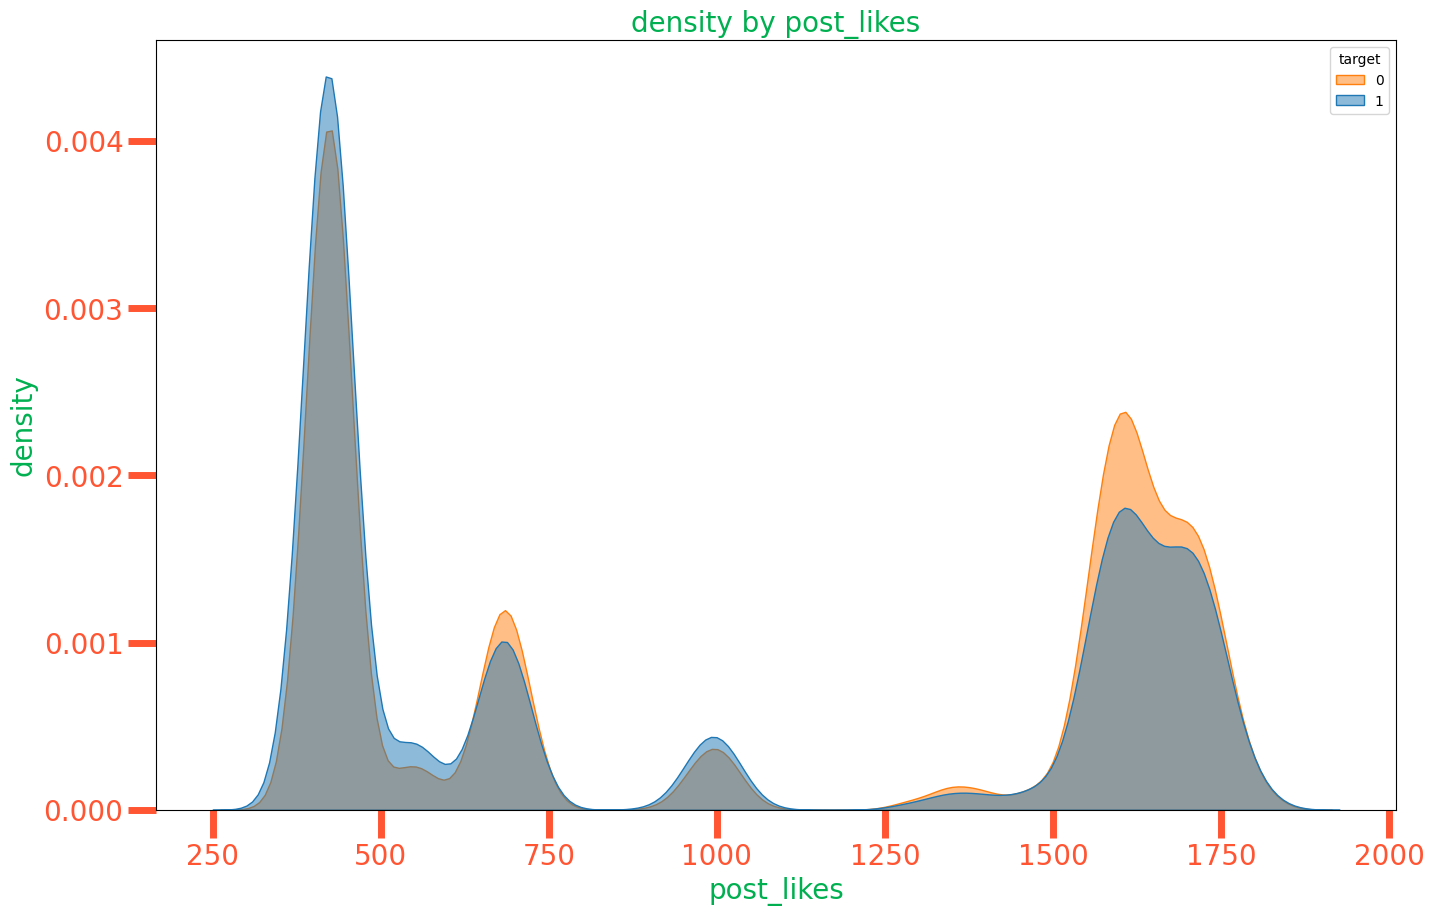

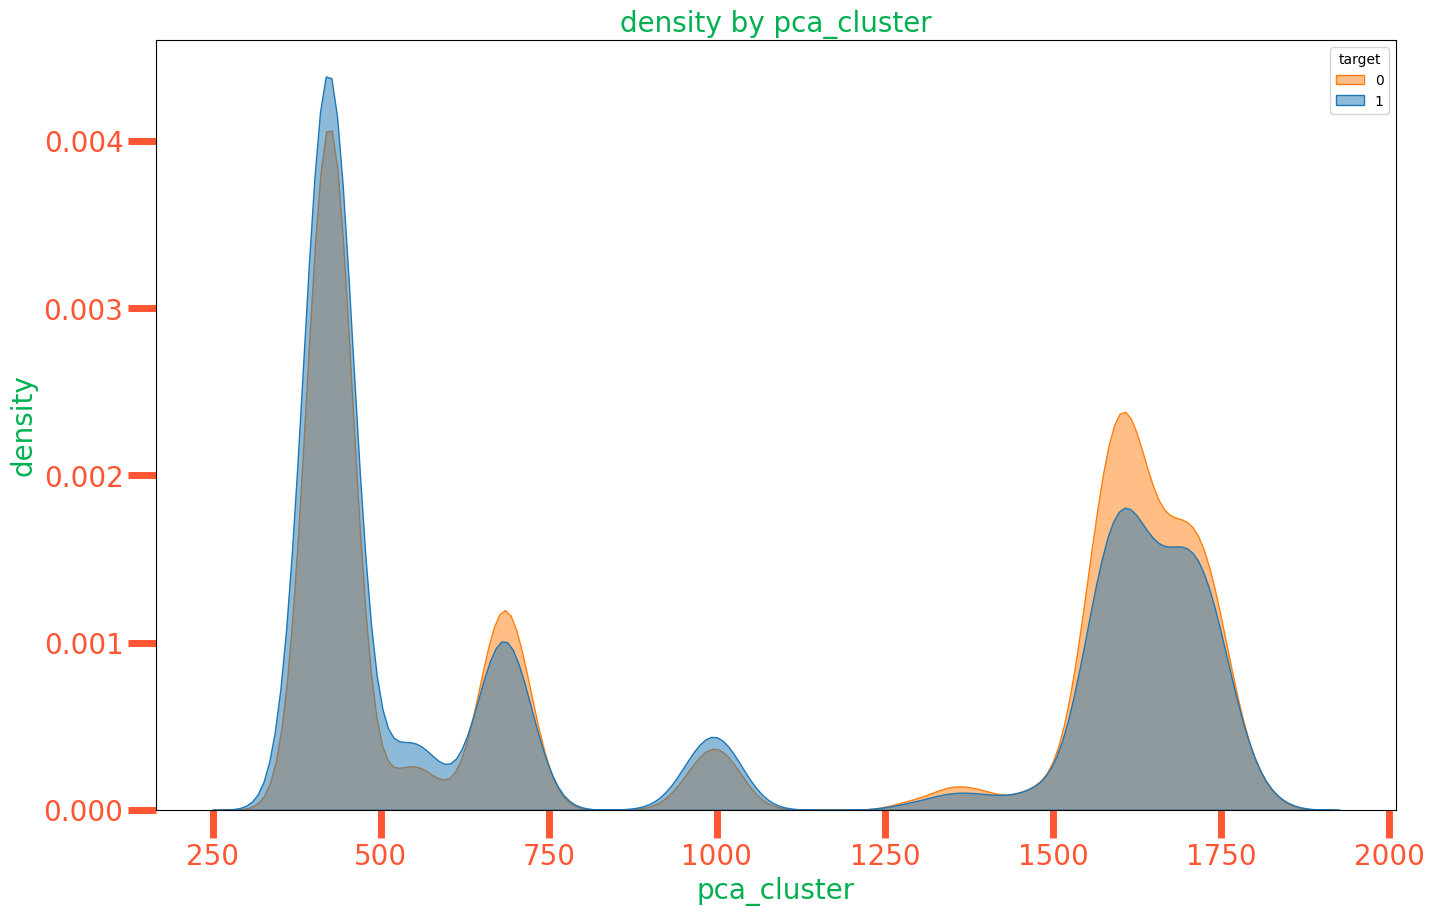

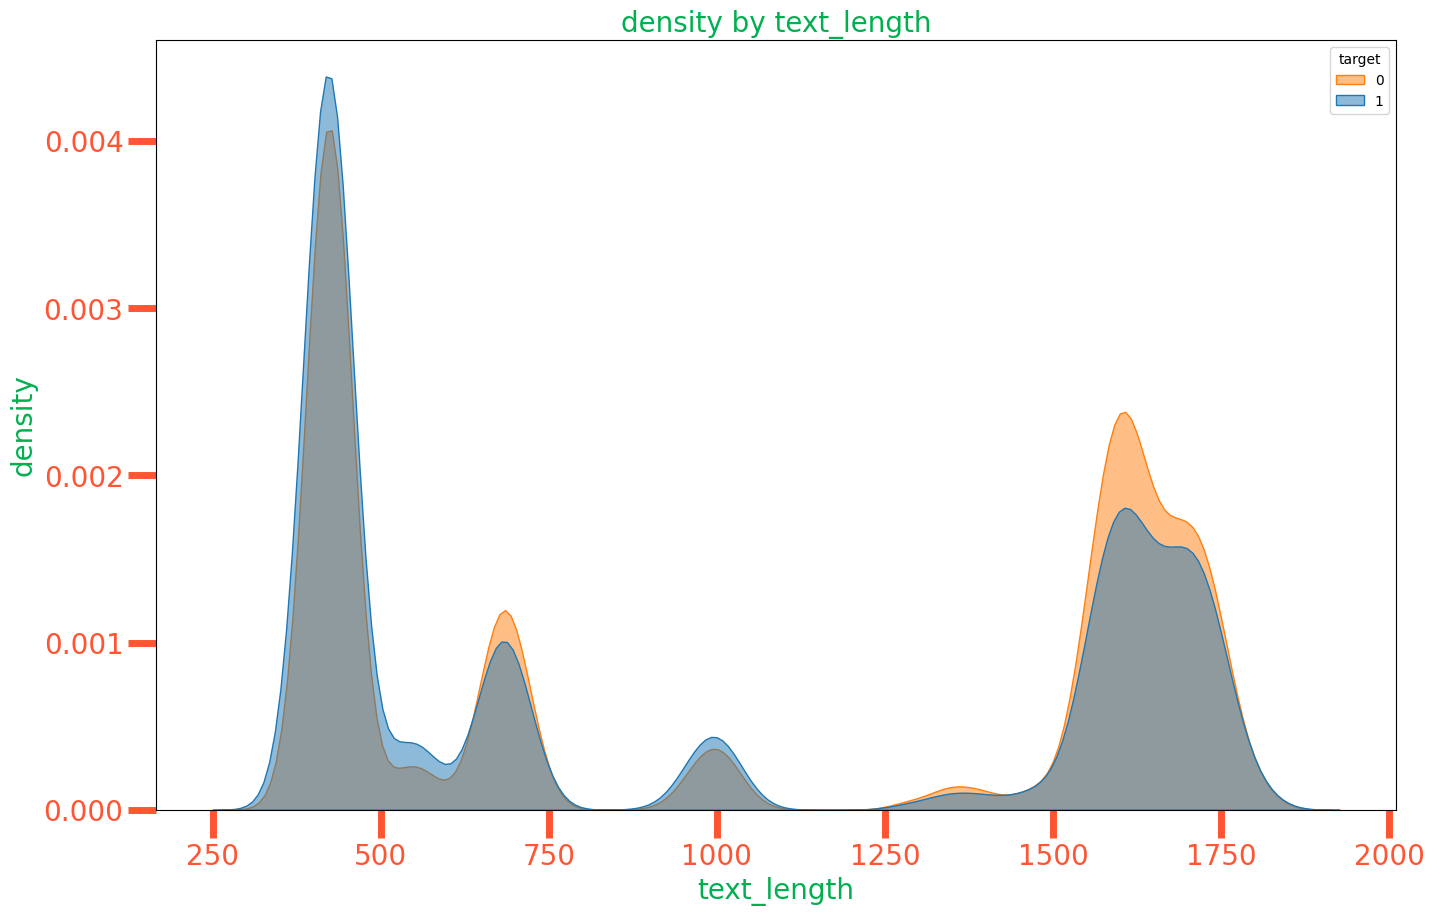

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

### Построение графика плотности

columns = ['user_views',  'post_likes', 'pca_cluster',	'text_length']

for column in columns:
    plt.figure(figsize=(16, 10))
    sns.kdeplot(data=data, x='post_likes', hue='target', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'density by {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('density')
    plt.legend(title='target', loc='upper right', labels=['0', '1'])
    plt.show()

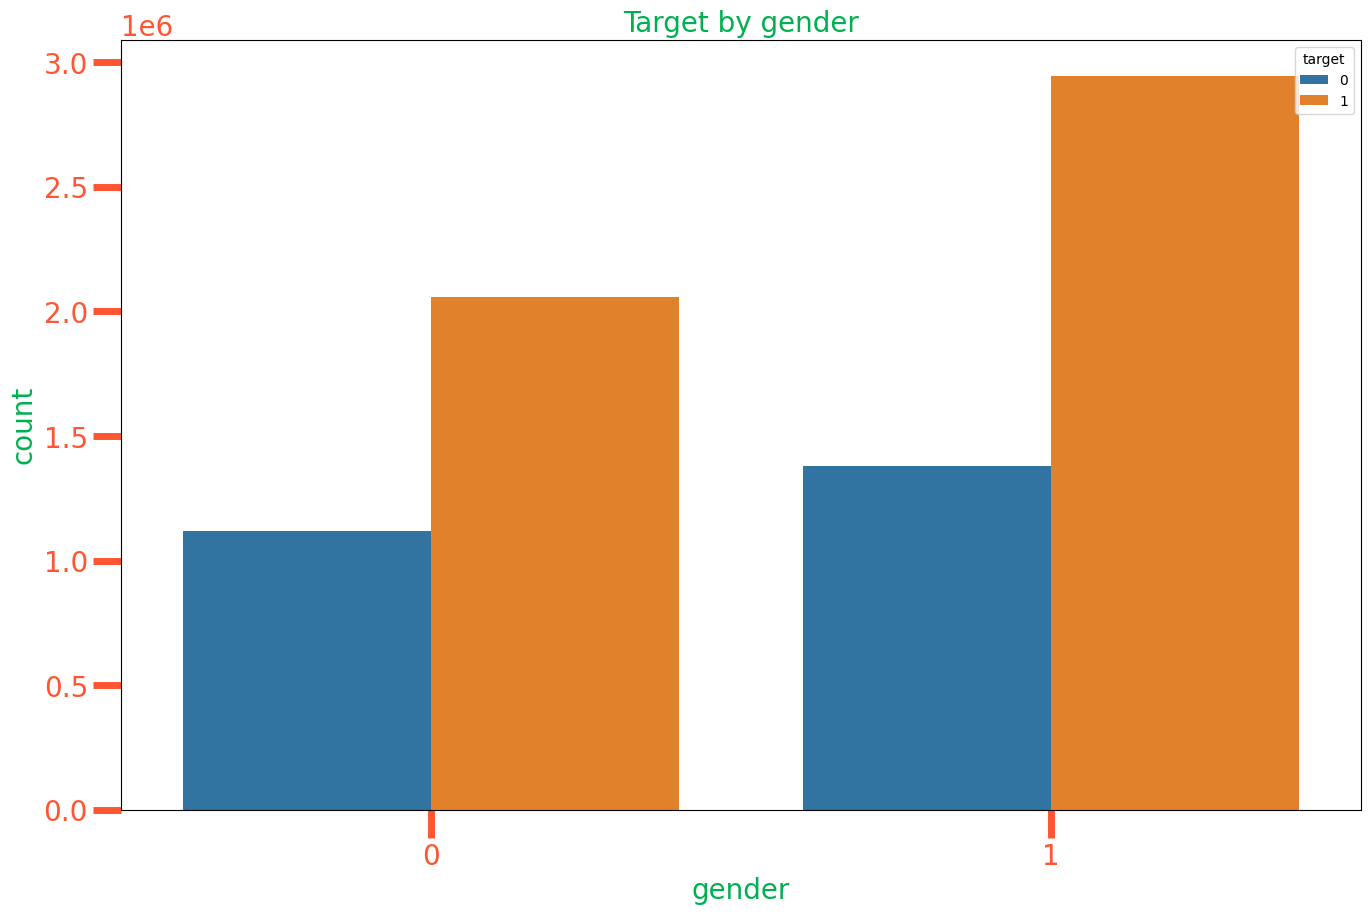

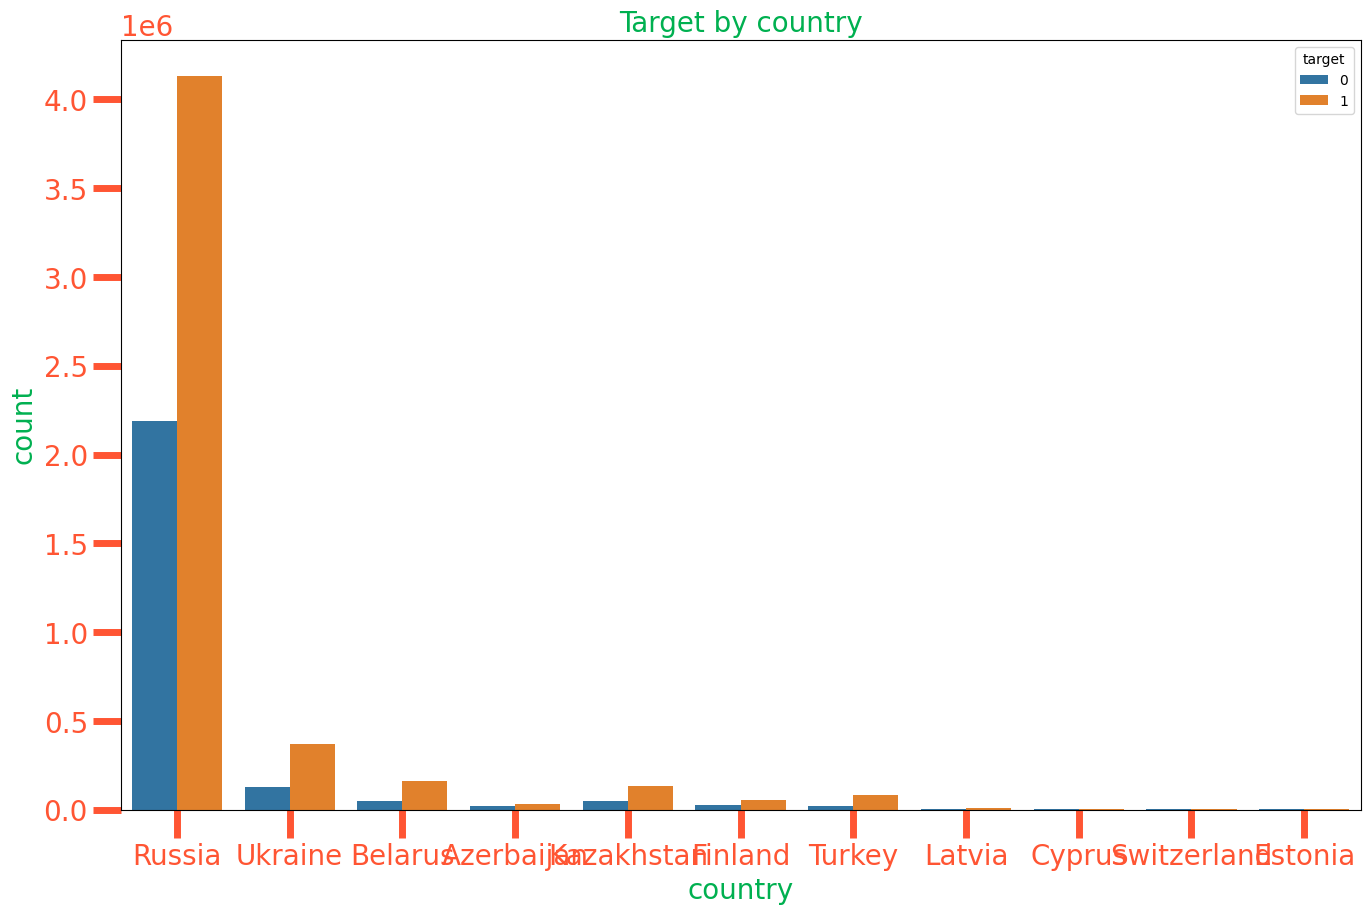

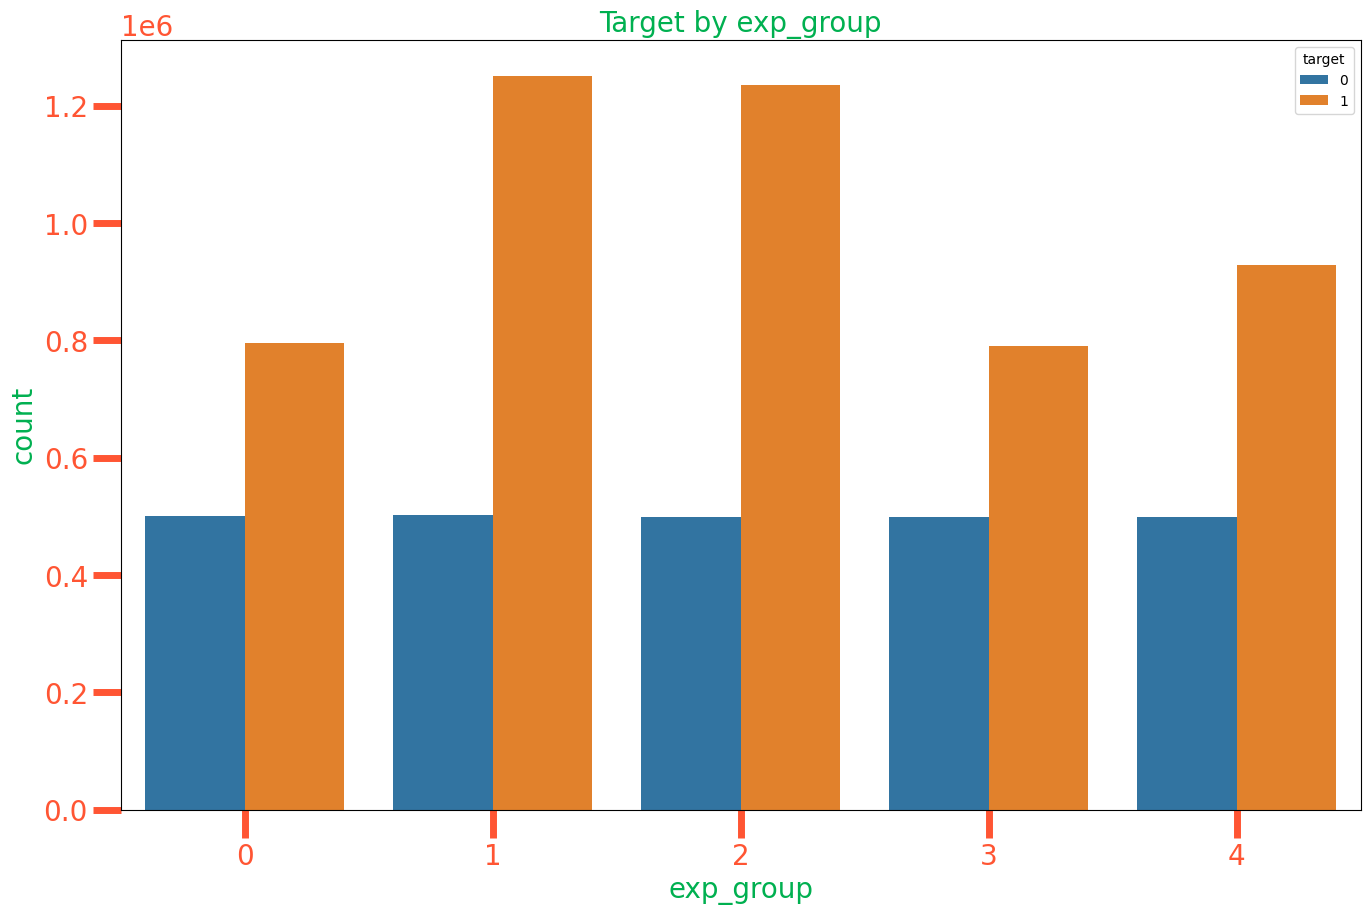

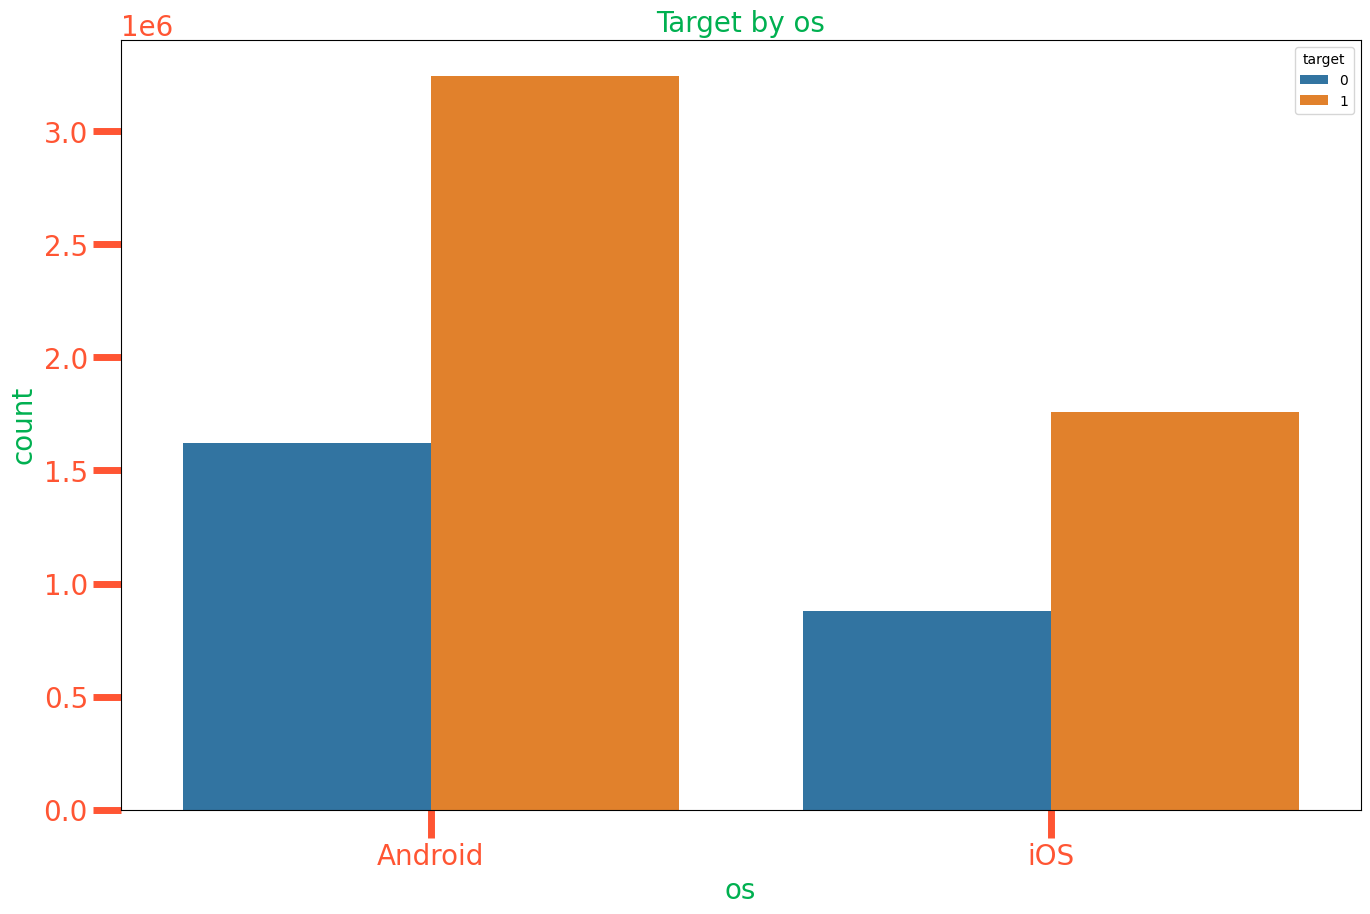

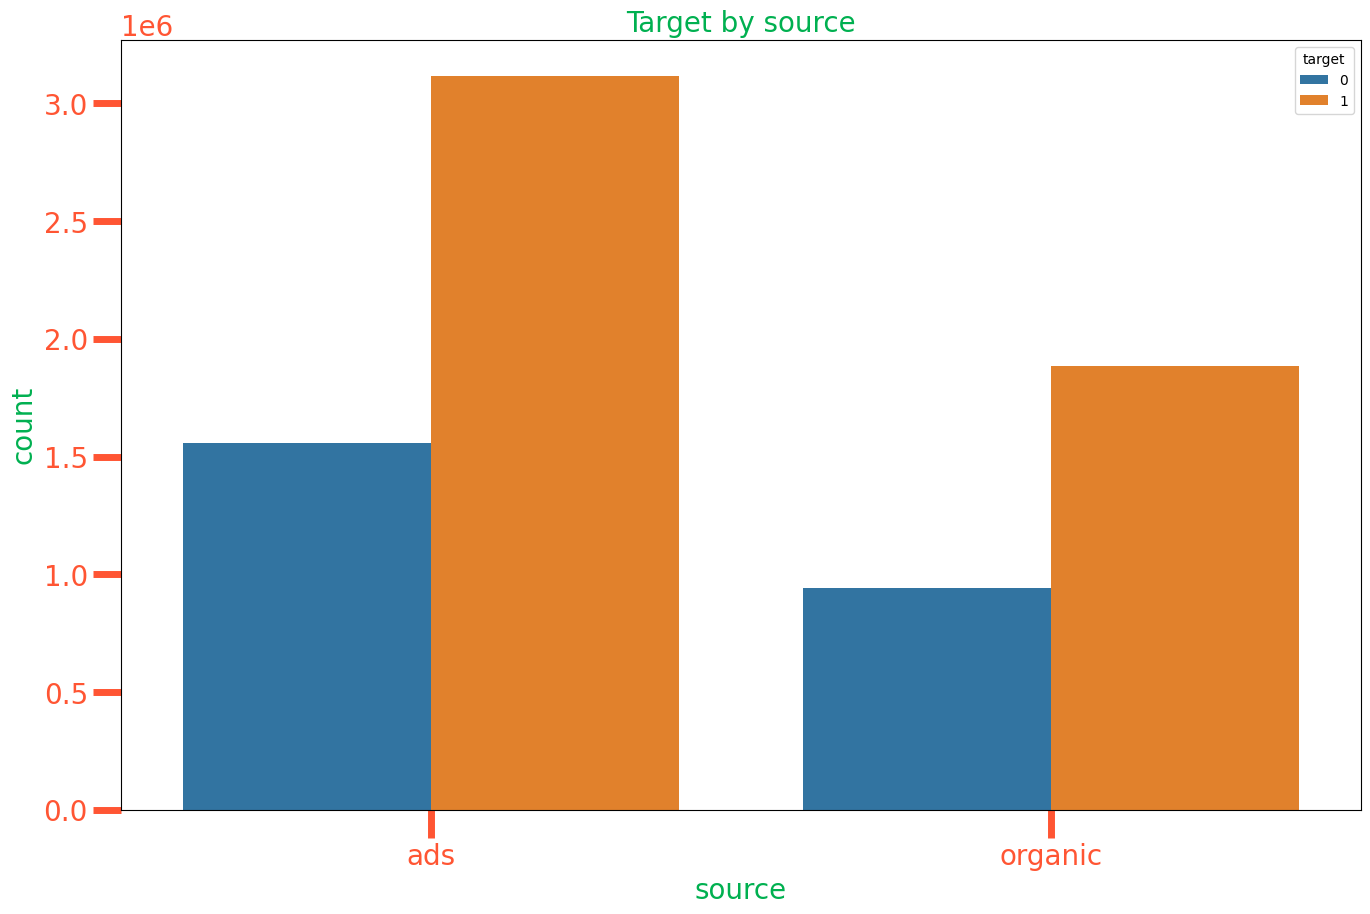

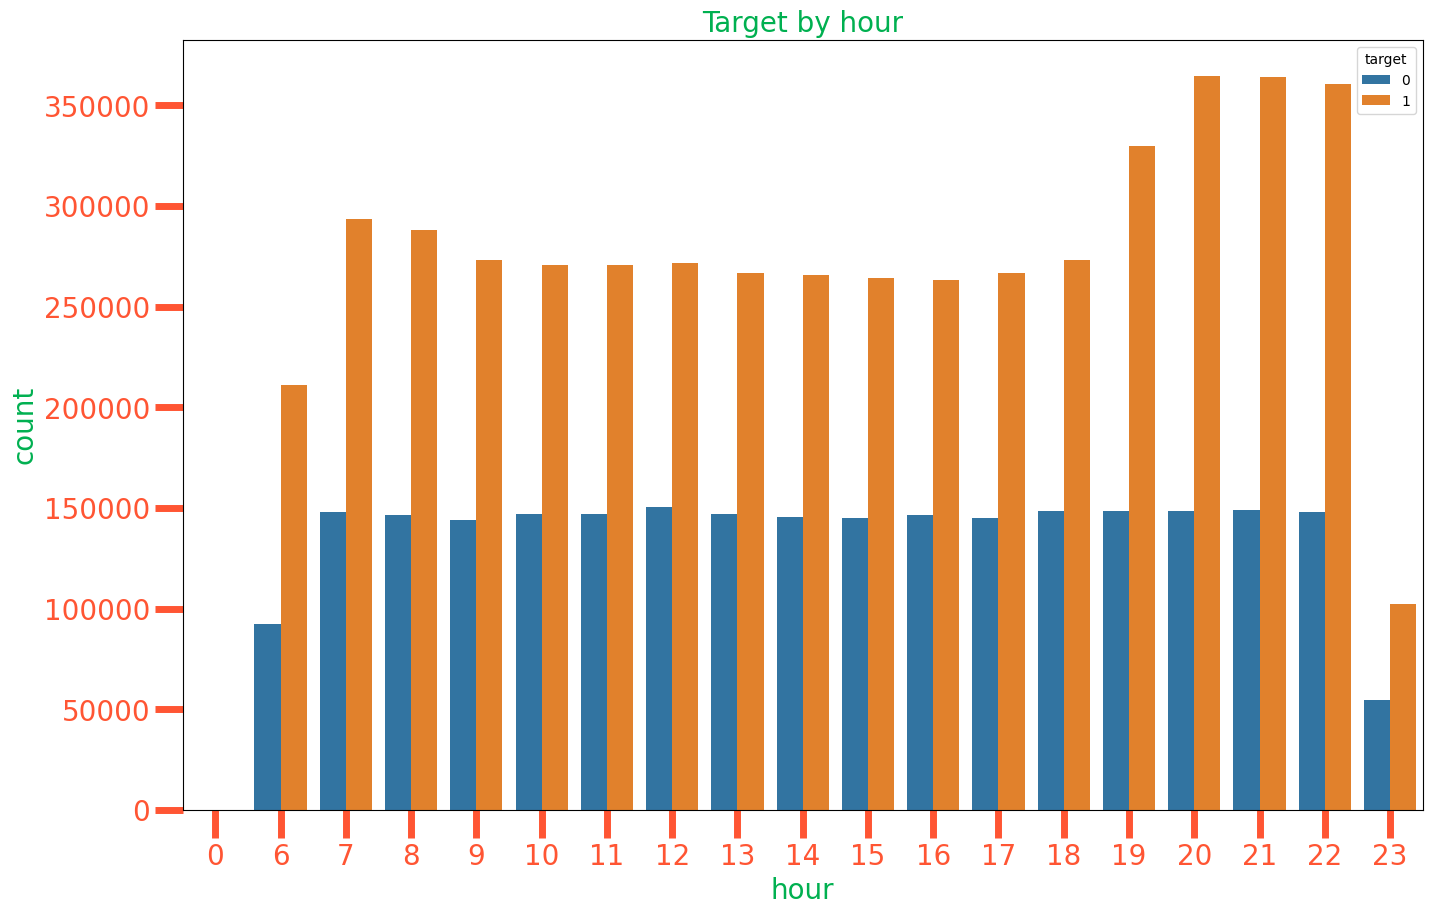

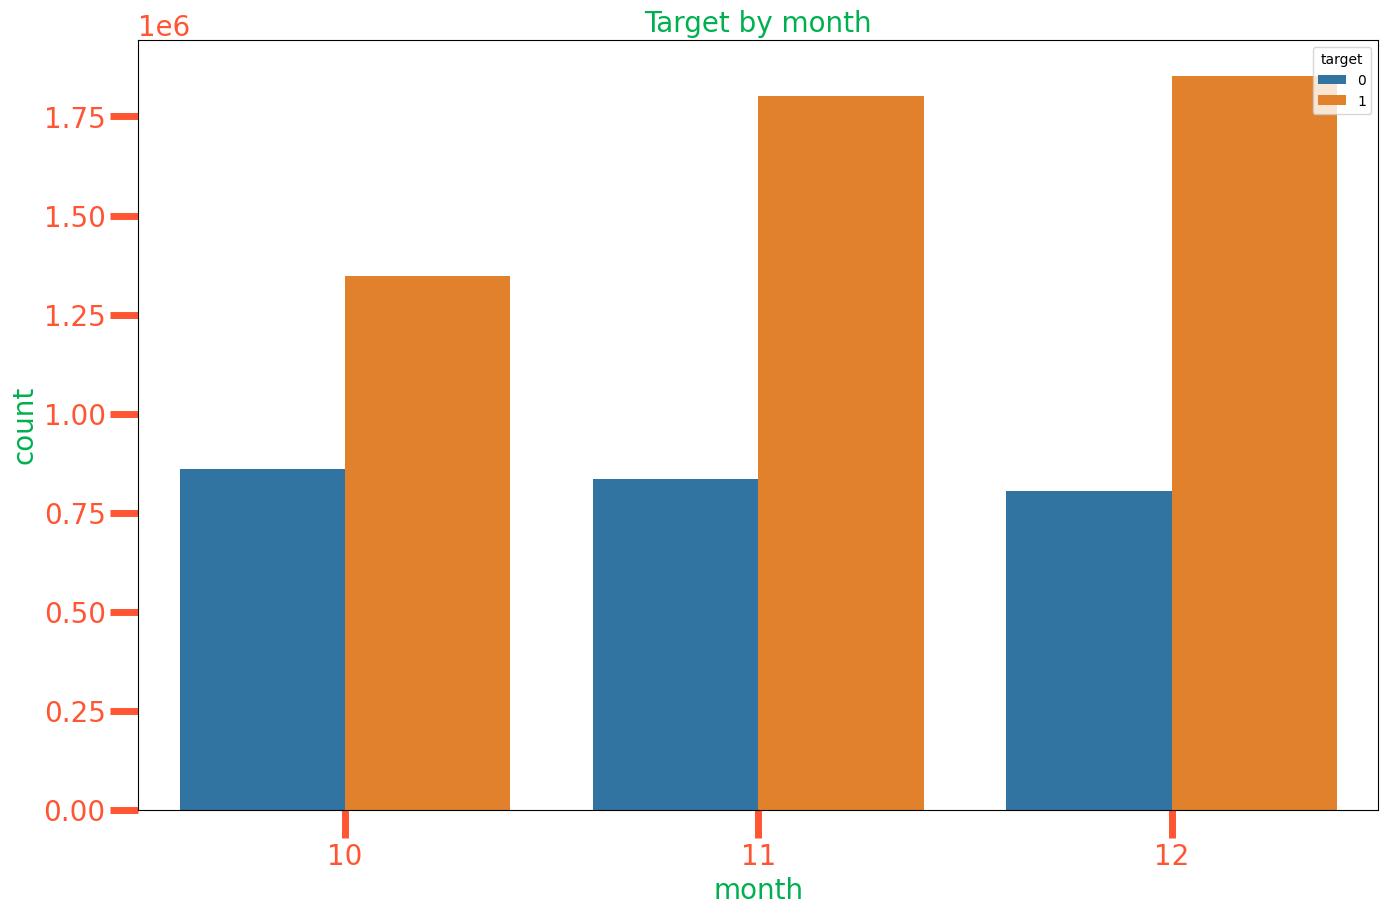

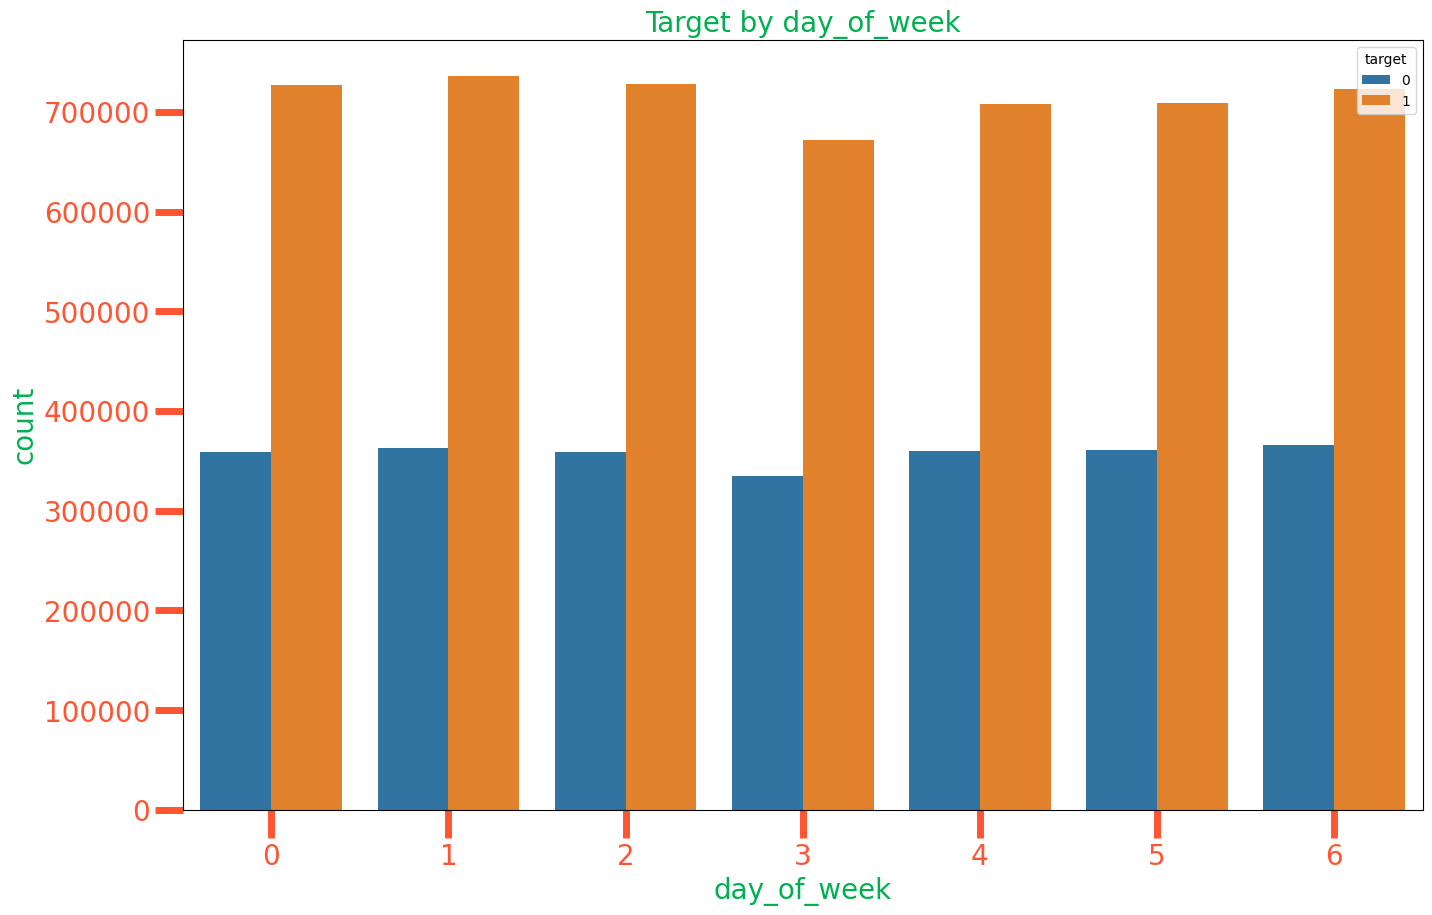

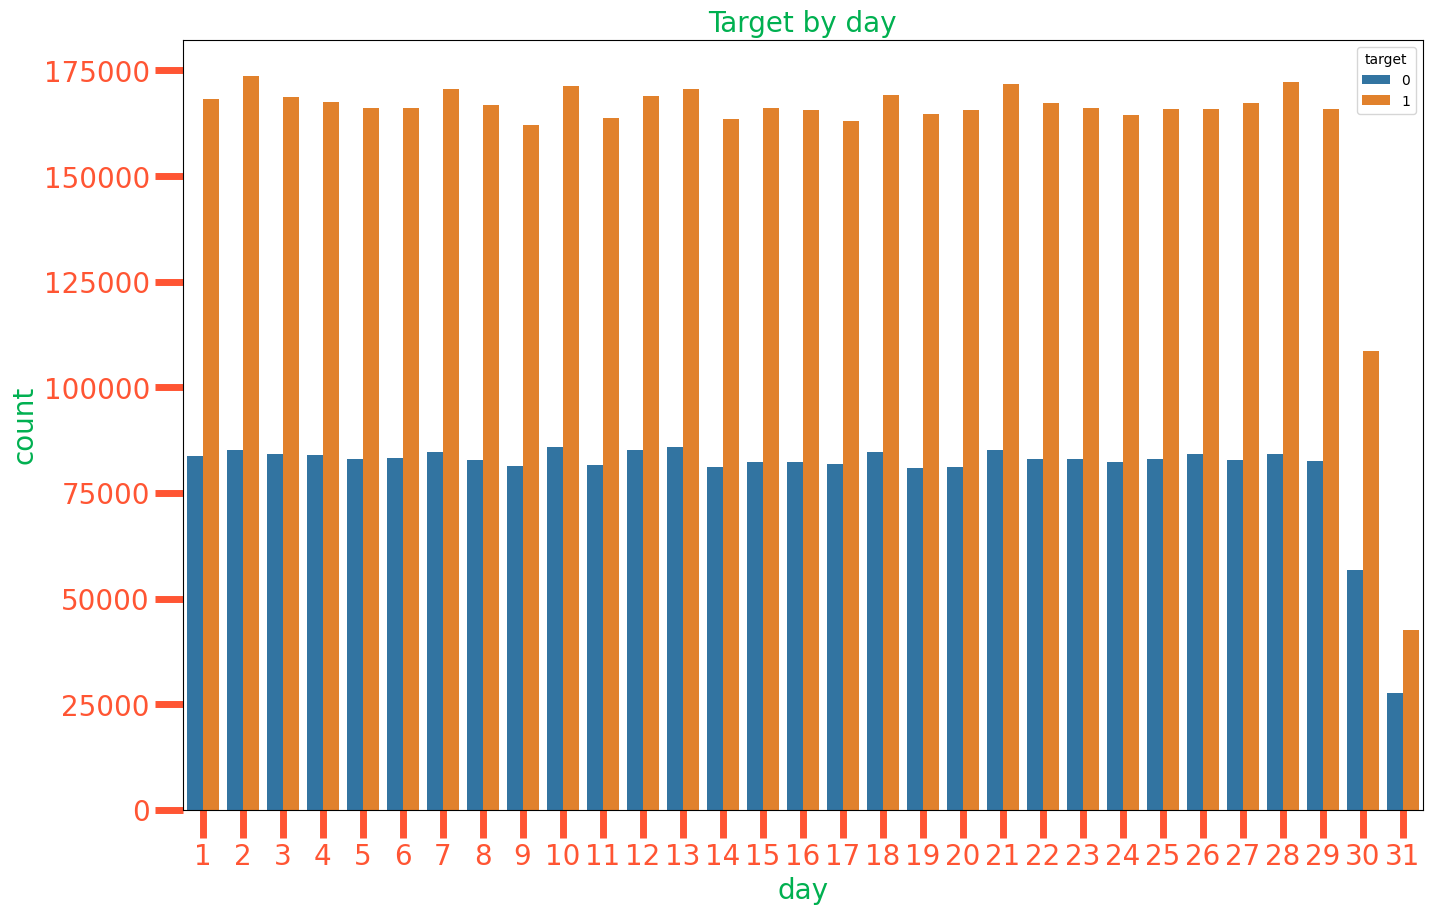

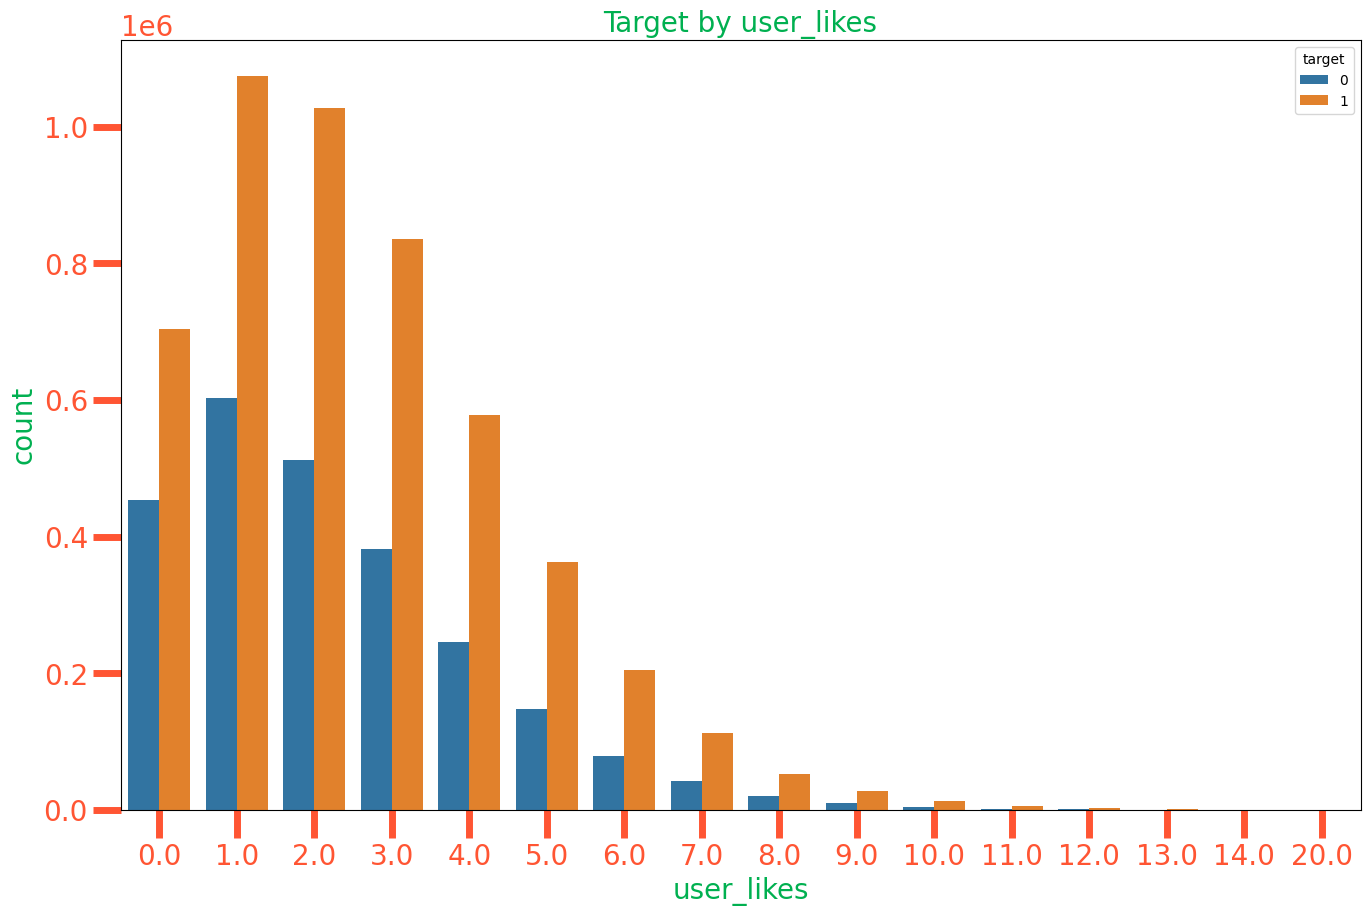

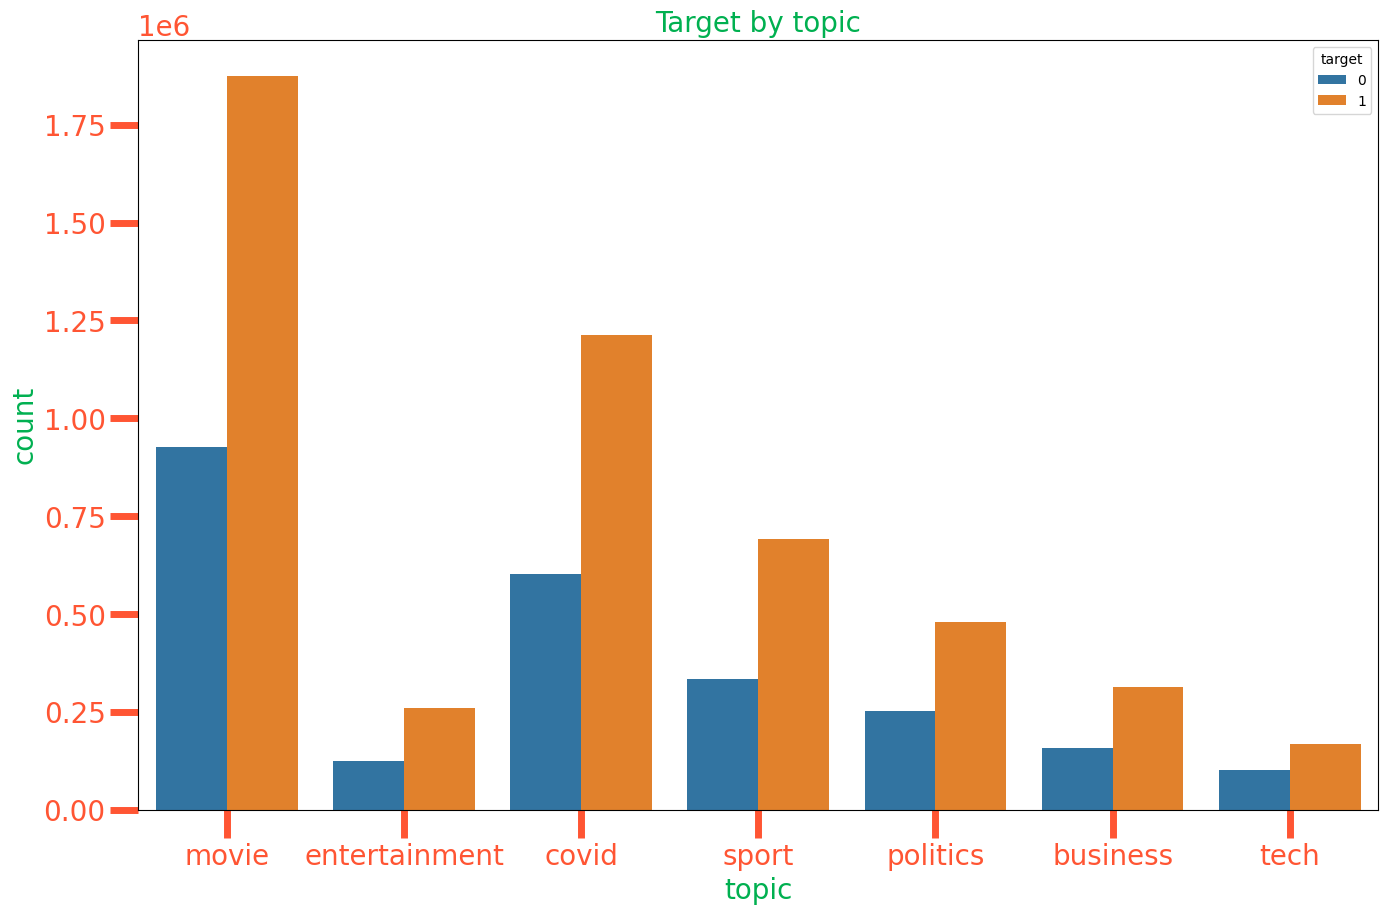

In [20]:
### Построение гистограмм

import matplotlib.pyplot as plt
import seaborn as sns

columns = ['gender', 'country', 'exp_group', 'os', 'source', 'hour', 'month', 'day_of_week', 'day', 
           'user_likes', 'topic']

for column in columns:
    plt.figure(figsize=(16, 10))
    sns.countplot(x=column, hue='target', data=data)
    plt.title(f'Target by {column}')
    plt.ylabel(f'count')
    plt.xlabel(column)
    plt.legend(title='target', loc='upper right', labels=['0', '1'])
    plt.show()


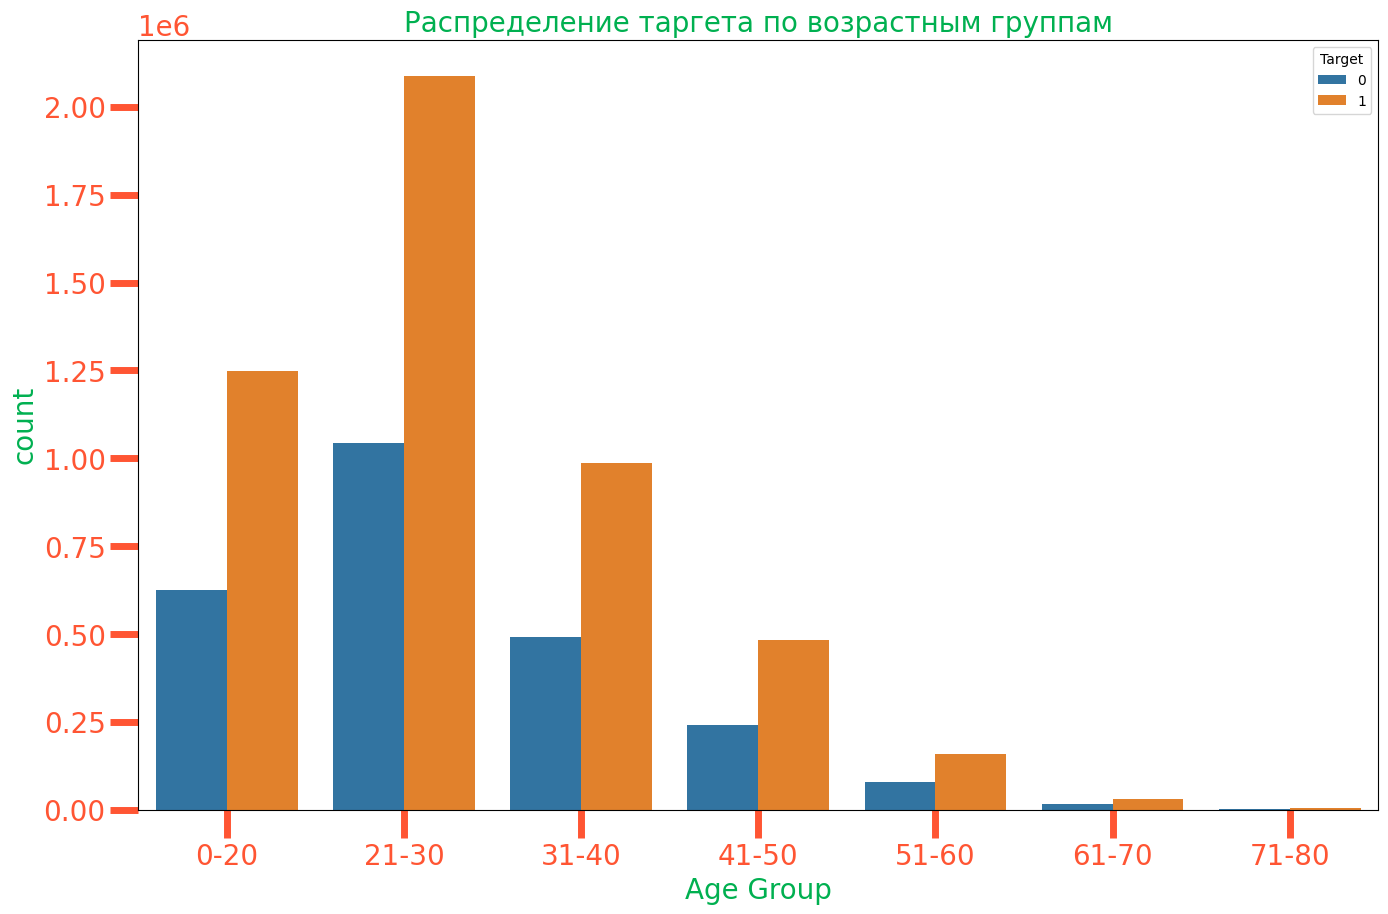

In [21]:
bins = [0, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Построение графика
plt.figure(figsize=(16, 10))
sns.countplot(x='age_group', hue='target', data=data)
plt.title('Распределение таргета по возрастным группам')
plt.ylabel('count')
plt.xlabel('Age Group')
plt.legend(title='Target', loc='upper right', labels=['0', '1'])
plt.show()

data = data.drop('age_group', axis=1)

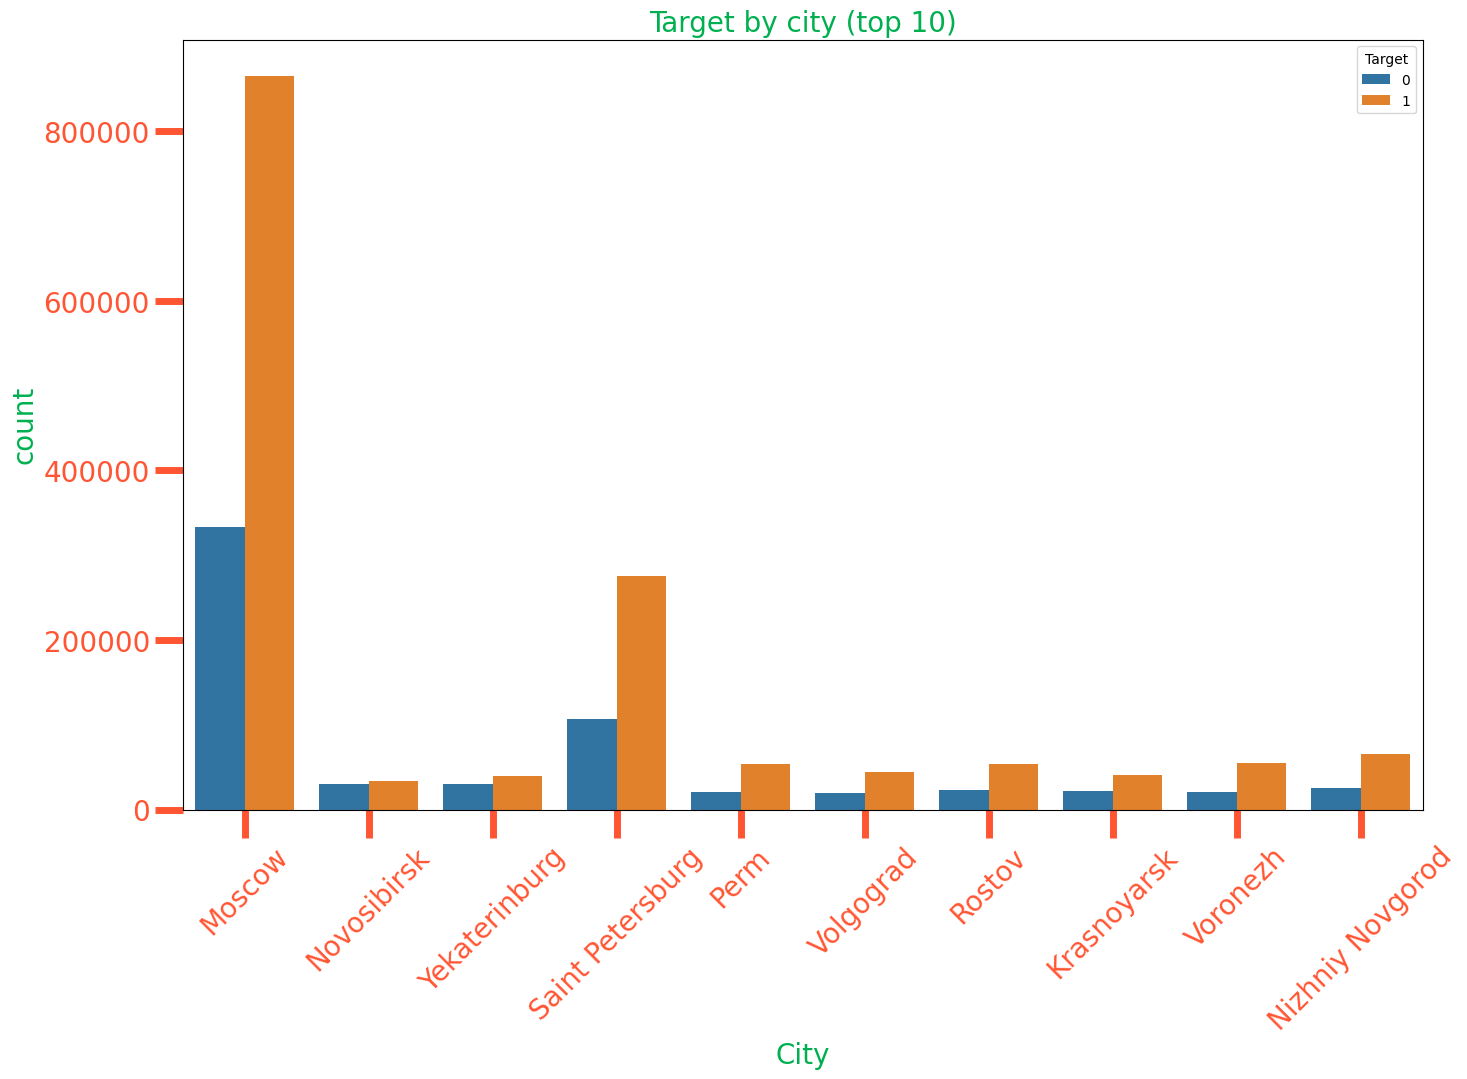

In [22]:
top_cities = data['city'].value_counts().nlargest(10).index

filtered_data = data[data['city'].isin(top_cities)]

plt.figure(figsize=(16, 10))
sns.countplot(x='city', hue='target', data=filtered_data)
plt.title('Target by city (top 10)')
plt.ylabel('count')
plt.xlabel('City')
plt.legend(title='Target', loc='upper right', labels=['0', '1'])
plt.xticks(rotation=45) 
plt.show()

In [23]:
data = data.drop('day_of_week', axis = 1)
data = data.drop('day', axis = 1)

In [24]:
### Кодирование категориальных переменных

for col in data.select_dtypes(include=['object']).columns:
    if data[col].nunique() < 3:
        one_hot = pd.get_dummies(data[col], drop_first=True, prefix = col)
        data = pd.concat((data.drop(col, axis=1), one_hot), axis=1)
    else:
        mean_target = data.groupby(col)['target'].mean()
        data[col] = data[col].map(mean_target)

In [25]:
data.head()

,user_id,post_id,target,gender,age,country,city,exp_group,hour,month,user_views,user_likes,post_likes,topic,pca_cluster,text_length,os_iOS,source_organic
0,200,6264,1,1,34,0.65345,0.709957,3,14,10,42,3.0,428,0.669267,17,3381,0,0
1,200,6264,0,1,34,0.65345,0.709957,3,14,10,42,3.0,428,0.669267,17,3381,0,0
2,200,6635,1,1,34,0.65345,0.709957,3,14,10,42,3.0,448,0.669267,17,483,0,0
3,200,668,1,1,34,0.65345,0.709957,3,15,10,42,3.0,649,0.673050,68,2581,0,0
4,200,2532,1,1,34,0.65345,0.709957,3,15,10,42,3.0,433,0.667670,2,135,0,0


In [26]:
### Дополнительные фичи

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X = data[['gender', 'country']]
Y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

pipeline = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)

data['country_gender_lm'] = pipeline.predict_proba(X)[:, 1]

In [27]:
from sklearn.cluster import KMeans

X = data[['age', 'source_organic']]

kmeans = KMeans(n_clusters=20, random_state=42)
data['age_gender_os_kmeans'] = kmeans.fit_predict(X)

In [28]:
from sklearn.cluster import KMeans

X = data[['age', 'gender', 'os_iOS']]

kmeans = KMeans(n_clusters=20, random_state=42)
data['age_gender_country_kmeans'] = kmeans.fit_predict(X)

In [29]:
data.head()

,user_id,post_id,target,gender,age,country,city,exp_group,hour,month,...,user_likes,post_likes,topic,pca_cluster,text_length,os_iOS,source_organic,country_gender_lm,age_gender_os_kmeans,age_gender_country_kmeans
0,200,6264,1,1,34,0.65345,0.709957,3,14,10,...,3.0,428,0.669267,17,3381,0,0,0.66818,15,19
1,200,6264,0,1,34,0.65345,0.709957,3,14,10,...,3.0,428,0.669267,17,3381,0,0,0.66818,15,19
2,200,6635,1,1,34,0.65345,0.709957,3,14,10,...,3.0,448,0.669267,17,483,0,0,0.66818,15,19
3,200,668,1,1,34,0.65345,0.709957,3,15,10,...,3.0,649,0.673050,68,2581,0,0,0.66818,15,19
4,200,2532,1,1,34,0.65345,0.709957,3,15,10,...,3.0,433,0.667670,2,135,0,0,0.66818,15,19


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500000 entries, 0 to 7499999
Data columns (total 21 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   post_id                    int64  
 2   target                     int64  
 3   gender                     int64  
 4   age                        int64  
 5   country                    float64
 6   city                       float64
 7   exp_group                  int64  
 8   hour                       int64  
 9   month                      int64  
 10  user_views                 int64  
 11  user_likes                 float64
 12  post_likes                 int64  
 13  topic                      float64
 14  pca_cluster                int32  
 15  text_length                int64  
 16  os_iOS                     uint8  
 17  source_organic             uint8  
 18  country_gender_lm          float64
 19  age_gender_os_kmeans       int32  
 20  ag

In [31]:
### Фильтрация признаков

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data, 15))

Top Absolute Correlations
country               country_gender_lm            0.898496
user_id               source_organic               0.837301
user_views            user_likes                   0.598568
city                  user_views                   0.480653
gender                country_gender_lm            0.434501
country               city                         0.400974
city                  user_likes                   0.369314
                      country_gender_lm            0.360935
age_gender_os_kmeans  age_gender_country_kmeans    0.350152
age                   post_likes                   0.308986
topic                 text_length                  0.303275
user_views            country_gender_lm            0.282508
pca_cluster           text_length                  0.277724
post_id               text_length                  0.274295
country               user_views                   0.264804
dtype: float64


In [32]:
### Удалим колонки, где корреляция оказывается > 0.9

def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] 
    
correlation(data, 0.9)

In [33]:
### Преобразуем размер

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].astype('float32')

In [34]:
### Подготовка данных для обучения
X = data.drop('target', axis=1)
y = data['target']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
### Метрика

def calculate_hitrate(y_true, y_pred_proba, k=5):
    hits = 0
    n = len(y_true)
    
    for i in range(n):
        # Получаем индексы топ-k вероятностей для текущего пользователя
        top_k_indices = np.argsort(y_pred_proba[i])[-k:] 
        
        # Проверяем, попадает ли хотя бы одно предсказанное значение в класс 1 (лайк)
        if any(y_true[i] == 1 for idx in top_k_indices):  # Сравниваем класс y_true с топ-k предсказаний
            hits += 1
    
    # Возвращаем долю пользователей, для которых был хотя бы один лайк в топ-k
    hitrate = hits / n
    return hitrate

In [36]:
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Обучение модели CatBoost
def train_catboost(X_train, y_train):
    catboost_model = CatBoostClassifier(verbose=0)
    param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'iterations': [100, 200, 300, 400],
        'l2_leaf_reg': [1, 3, 5],
    }
    
    best_hitrate = 0
    best_model = None
    best_params = None  
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        random_search = RandomizedSearchCV(catboost_model, param_grid, scoring='roc_auc', cv=3, 
                                           n_iter=20, random_state=42)
        random_search.fit(X_train_fold, y_train_fold)
        
        y_val_pred_proba = random_search.predict_proba(X_val_fold)[:, 1]
        hitrate = calculate_hitrate(y_val_fold.values, y_val_pred_proba)
        
        if hitrate > best_hitrate:
            best_hitrate = hitrate
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_

    print("Лучшие параметры:", best_params)   
    return best_model 


catboost_model = train_catboost(X_train, y_train)

Лучшие параметры: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 8}


In [37]:
### Замерим качество работы
from sklearn.metrics import roc_auc_score

print(f"Train quality: {roc_auc_score(y_train, catboost_model.predict_proba(X_train)[:, 1])}")
print(f"Test quality: {roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])}")

Train quality: 0.7007218411087498
Test quality: 0.699871893651


In [38]:
### Сохранение модели
catboost_model.save_model('model_test', format="cbm") 

In [47]:
data.to_csv('data_test.csv')